# Structure from motion

Import everything *except* our sfm library.

In [1]:
# Import symforce for the sole purpose of setting the value
# of epsilon, which must be done first and exactly once.
import symforce
symforce.set_epsilon_to_symbol()

import importlib
from pathlib import Path
import numpy as np
import secrets
import cv2
import matplotlib.pyplot as plt
from matplotlib.patches import ConnectionPatch
import rerun as rr
from uuid import uuid4

from pupil_apriltags import Detector
import json

Import our sfm library. (Re-evaluate this cell if you make changes to the library.)

In [2]:
import sfm
importlib.reload(sfm)

<module 'sfm' from '/Users/sam/Documents/phd/AE598/Air-to-air-3dv/sfm.py'>

Choose parameter values.

In [8]:
# When reading video frames
frames_to_skip = 20

# When matching (max threshold for ratio test)
matching_threshold = 0.5

# When deciding if triangulated points are invalid
max_reprojection_err = 0.85

# Camera matrix
K = np.array([
    [1223.359872901537, 0.0, 1014.9134915659537],
    [0.0, 1225.3894727126913, 459.47404470286574],
    [0.0, 0.0, 1.0],
])

Create random number generator.

In [4]:
seed = secrets.randbits(32)
print(f'seeding RNG with {seed}')
rng = np.random.default_rng(seed)

seeding RNG with 764757795


Initialize 3D visualizer (should open the rerun application if that isn't already open).

In [5]:
# Create recording with unique ID
rr.init('my_sfm', recording_id=uuid4(), spawn=True)

# Initialize a time sequence
rr.set_time_seconds('stable_time', 0)

# Make view coordinates consistent with camera frames (z forward, x right, y down)
rr.log('/results', rr.ViewCoordinates.RDF, timeless=True)

Load images from video.

In [6]:
def getmask(img, light, dark):
    rgb_img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    hsv_img = cv2.cvtColor(rgb_img, cv2.COLOR_RGB2HSV)

    mask = cv2.inRange(hsv_img, light, dark)
    hsv_result_hsv = cv2.bitwise_and(hsv_img, hsv_img, mask=mask)
    
    hsv_result_brg = cv2.cvtColor(hsv_result_hsv, cv2.COLOR_HSV2BGR)
    hsv_result = cv2.cvtColor(hsv_result_brg, cv2.COLOR_BGR2GRAY)
    
    return mask, hsv_result
    
def crop(img, size):
    img = img[480:1440, 270:810] # crop
    return img


In [9]:
# Specify filename
video_filename = Path('../chaseVideoSix.mp4') # chaseVideoOne
light = (0, 0, 200) # hsv value for light end of airplane range
dark = (145, 60, 255) # hsv value for dark end of airplane range

# Create a video reader
video_src = cv2.VideoCapture(str(video_filename))

# Get frame count and frames per second
frame_count = int(video_src.get(cv2.CAP_PROP_FRAME_COUNT))
frames_per_second = video_src.get(cv2.CAP_PROP_FPS)

# Read frames
views = []
for i_frame in range(0, frame_count, frames_to_skip):
    video_src.set(cv2.CAP_PROP_POS_FRAMES, i_frame)
    success, frame = video_src.read()
    assert(success)
    img = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)
    mask, masked = getmask(img, light, dark)
    views.append({
        'frame_id': i_frame,
        'frame': frame,
        'img': img,
        'mask': mask,
        'masked': masked,
        'R_inB_ofA': None,
        'p_inB_ofA': None,
    })
print(f'read {len(views)} images from video')

read 3 images from video


Detection.

In [10]:
# grid tag detection
template_filename = Path(".", 'tag36_11_grid_5x8-template.json')
with open(template_filename, 'r') as f:
    template = json.load(f)
    
tag_detector = Detector(
    families=template['tag_family'],
    nthreads=1,
    quad_decimate=1.0,
    quad_sigma=0.0,
    refine_edges=1,
    decode_sharpening=0.,
    debug=0,
)

def get_tag_with_id(tag_id, template):
    for tag in template['tags']:
        if tag['tag_id'] == tag_id:
            return tag
    raise Exception(f'tag_id {tag_id} not found in template')

In [15]:
# detect tags

# Tag corners must be no less than this number of pixels from the image border
buffer_px = 10

# Iterate over all images in the source directory
for view in views:    
    # Read image as grayscale
    img = view['img']
    
    # Detect tags
    tag_detections = tag_detector.detect(
        img,
        estimate_tag_pose=True,
        camera_params=np.array([K[0,0], K[1,1], K[0,2], K[1,2]]),
        tag_size=0.024,
    )
    
    rejected_tags = []
    tags = []
    p = []
    q = []
    for d in tag_detections:

        # Reject tags with corners too close to the image boundary
        if ((d.corners[:, 0] < buffer_px).any() or
            (d.corners[:, 0] > (img.shape[1] - 1) - buffer_px).any() or
            (d.corners[:, 1] < buffer_px).any() or
            (d.corners[:, 1] > (img.shape[0] - 1) - buffer_px).any()):
            continue
        
        # Add tag to list of detected tags
        tags.append({
            'tag_id': d.tag_id,
            'corners': d.corners.tolist(),
            'center': d.center,
            'R': d.pose_R,
            'p': d.pose_t,
            'error': d.pose_err,
        })
        
        # Add corners of tag to point correspondences
        p.extend(get_tag_with_id(d.tag_id, template)['corners'])
        q.extend(d.corners.tolist())
        
    view['tags'] = tags # commented
    
    # Make sure the lengths of p and q are consistent
    assert(len(p) == len(q))
    
    # Count the number of tags and correspondences that were found
    num_tags = len(tags)
    num_points = len(p)
    

In [16]:
for view in views:
    #view['pts'] = []
    pts = []
    desc = []
    for tag in view["tags"]:
        for i in np.arange(0, len(tag["corners"]), 1):
            pts.append(
                {
                    'pt2d': np.array(tag["corners"][i]),
                    'track': None,
                }
            )
            desc.append([str(tag["tag_id"])+str(i)])
            
        
    view['pts'] = pts
    view['desc'] = desc

    #view['pts'] = view['pts'][0]

In [13]:
print((views[0]["tags"]))

[{'tag_id': 0, 'corners': [[667.0513305664062, 467.8562316894531], [700.2265014648438, 465.7137451171875], [691.1016235351564, 434.45550537109375], [658.0085449218751, 437.1731262207032]], 'center': array([678.9506457 , 451.33062143]), 'R': array([[ 0.98573946,  0.1324152 ,  0.10384574],
       [-0.0679263 ,  0.87769481, -0.47438154],
       [-0.1539602 ,  0.46056274,  0.87417288]]), 'p': array([[-0.22953424],
       [-0.00550626],
       [ 0.83616338]]), 'error': 4.4192197697498336e-08}, {'tag_id': 2, 'corners': [[1370.313232421875, 232.8419494628906], [1412.7733154296877, 227.55003356933597], [1411.1954345703125, 189.48138427734375], [1368.1542968749998, 194.7388458251953]], 'center': array([1390.64496959,  211.27766064]), 'R': array([[ 0.96348259,  0.20734917,  0.16943325],
       [-0.07761663,  0.82184805, -0.56439475],
       [-0.25627516,  0.53063368,  0.80793003]]), 'p': array([[ 0.22004151],
       [-0.14512529],
       [ 0.71666976]]), 'error': 2.1472096865642502e-08}, {'tag_i

## Initialize with two-view reconstruction

### Get initial guess

Apply matcher.

Store results.

In [14]:
#OLD VERSION, DO NOT USE

# build a list of which tag ids appear 
tags_0 = []
tags_1 = []
for i in np.arange(0,len(views[0]['tags']),1): tags_0.append(views[0]['tags'][i]['tag_id'])
for i in np.arange(0,len(views[1]['tags']),1): tags_1.append(views[1]['tags'][i]['tag_id'])

tags = []
for tag in tags_0: 
    if (tag in tags_1): 
        tags.append(tag)
        
#print(tags)
#print(tags_0)
#print(tags_1)

tracks_tags = []

for tag in tags:
    for i in np.arange(0,4,1):
        track = {
            'p_inA': None,
            'valid': True,
            'matches': [
                {'view_id': 0, 'tag_id': tag, 'corner': i},
                {'view_id': 1, 'tag_id': tag, 'corner': i},
            ]
        }
        tracks_tags.append(track)
        #views[0]['pts'][tracks_tags.queryIdx]['track'] = track
        #views[1]['pts'][tracks_tags.trainIdx]['track'] = track
    
print(tracks_tags)
print(len(tracks_tags))

[{'p_inA': None, 'valid': True, 'matches': [{'view_id': 0, 'tag_id': 0, 'corner': 0}, {'view_id': 1, 'tag_id': 0, 'corner': 0}]}, {'p_inA': None, 'valid': True, 'matches': [{'view_id': 0, 'tag_id': 0, 'corner': 1}, {'view_id': 1, 'tag_id': 0, 'corner': 1}]}, {'p_inA': None, 'valid': True, 'matches': [{'view_id': 0, 'tag_id': 0, 'corner': 2}, {'view_id': 1, 'tag_id': 0, 'corner': 2}]}, {'p_inA': None, 'valid': True, 'matches': [{'view_id': 0, 'tag_id': 0, 'corner': 3}, {'view_id': 1, 'tag_id': 0, 'corner': 3}]}, {'p_inA': None, 'valid': True, 'matches': [{'view_id': 0, 'tag_id': 2, 'corner': 0}, {'view_id': 1, 'tag_id': 2, 'corner': 0}]}, {'p_inA': None, 'valid': True, 'matches': [{'view_id': 0, 'tag_id': 2, 'corner': 1}, {'view_id': 1, 'tag_id': 2, 'corner': 1}]}, {'p_inA': None, 'valid': True, 'matches': [{'view_id': 0, 'tag_id': 2, 'corner': 2}, {'view_id': 1, 'tag_id': 2, 'corner': 2}]}, {'p_inA': None, 'valid': True, 'matches': [{'view_id': 0, 'tag_id': 2, 'corner': 3}, {'view_id':

In [17]:
# build a list of which tag ids appear 
tags_0 = []
tags_1 = []
for i in np.arange(0,len(views[0]['tags']),1): tags_0.append(views[0]['tags'][i]['tag_id'])
for i in np.arange(0,len(views[1]['tags']),1): tags_1.append(views[1]['tags'][i]['tag_id'])

tags = []
for tag in tags_0: 
    if (tag in tags_1): 
        tags.append(tag)
        
#print(tags)
#print(tags_0)
#print(tags_1)

tracks_tags = []

for tag in tags:
    for i in np.arange(0,4,1):
        track = {
            'p_inA': None,
            'valid': True,
            'matches': [
                {'view_id': 0, 'feature_id': (str(tag)+str(i))},
                {'view_id': 1, 'feature_id': (str(tag)+str(i))},
            ]
        }
        tracks_tags.append(track)
        
        desc = str(track['matches'][0]['feature_id'])
        index_a = int(np.where(np.array(views[track["matches"][0]["view_id"]]["desc"]) == desc)[0][0])
        index_b = int(np.where(np.array(views[track["matches"][1]["view_id"]]["desc"]) == desc)[0][0])
        
        print(index_a, index_a)
        
        views[0]['pts'][index_a]['track'] = track
        views[1]['pts'][index_b]['track'] = track
    
print(tracks_tags)
print(len(tracks_tags))


0 0
1 1
2 2
3 3
4 4
5 5
6 6
7 7
8 8
9 9
10 10
11 11
12 12
13 13
14 14
15 15
16 16
17 17
18 18
19 19
[{'p_inA': None, 'valid': True, 'matches': [{'view_id': 0, 'feature_id': '00'}, {'view_id': 1, 'feature_id': '00'}]}, {'p_inA': None, 'valid': True, 'matches': [{'view_id': 0, 'feature_id': '01'}, {'view_id': 1, 'feature_id': '01'}]}, {'p_inA': None, 'valid': True, 'matches': [{'view_id': 0, 'feature_id': '02'}, {'view_id': 1, 'feature_id': '02'}]}, {'p_inA': None, 'valid': True, 'matches': [{'view_id': 0, 'feature_id': '03'}, {'view_id': 1, 'feature_id': '03'}]}, {'p_inA': None, 'valid': True, 'matches': [{'view_id': 0, 'feature_id': '20'}, {'view_id': 1, 'feature_id': '20'}]}, {'p_inA': None, 'valid': True, 'matches': [{'view_id': 0, 'feature_id': '21'}, {'view_id': 1, 'feature_id': '21'}]}, {'p_inA': None, 'valid': True, 'matches': [{'view_id': 0, 'feature_id': '22'}, {'view_id': 1, 'feature_id': '22'}]}, {'p_inA': None, 'valid': True, 'matches': [{'view_id': 0, 'feature_id': '23'}, {

Get image coordinates of matches.

In [18]:
views[0]['pts'][0]["track"]

{'p_inA': None,
 'valid': True,
 'matches': [{'view_id': 0, 'feature_id': '00'},
  {'view_id': 1, 'feature_id': '00'}]}

In [19]:
view = views[0]

#print(view["tags"][0])

In [20]:
track = tracks_tags[3]
print(track["matches"][0])

x = str(track["matches"][0]["feature_id"])
print(x)

#print(views[track["matches"][0]["view_id"]])

#print(np.array(views[track["matches"][0]["view_id"]]["desc"]))

print(int(np.where(np.array(views[track["matches"][0]["view_id"]]["desc"]) == x)[0][0]))

x = int(np.where(np.array(views[track["matches"][0]["view_id"]]["desc"]) == x)[0][0])

print(np.array(views[track["matches"][0]["view_id"]]["pts"][x][0]['pt2d']))

print(track)

print(view['pts'][x])




{'view_id': 0, 'feature_id': '03'}
03
3


KeyError: 0

In [21]:
# Create a, b from 
a = []
b = []
for track in tracks_tags:
    #print(track["matches"][0])
    #print(views[track["matches"][0]["view_id"]]["tags"][]["corners"][track["matches"][0]["corner"]])
    desc = str(track['matches'][0]['feature_id'])
    
    index_a = int(np.where(np.array(views[track["matches"][0]["view_id"]]["desc"]) == desc)[0][0])
    corner_a = np.array(views[track["matches"][0]["view_id"]]["pts"][index_a]['pt2d'])
    
    index_b = int(np.where(np.array(views[track["matches"][1]["view_id"]]["desc"]) == desc)[0][0])
    corner_b = np.array(views[track["matches"][1]["view_id"]]["pts"][index_b]['pt2d'])
    
    #for i in np.arange(0, len(corners_a[0]), 1):
    a.append(corner_a)
    b.append(corner_b)
    
a = np.array(a)
b = np.array(b)

Visualize all good matches.

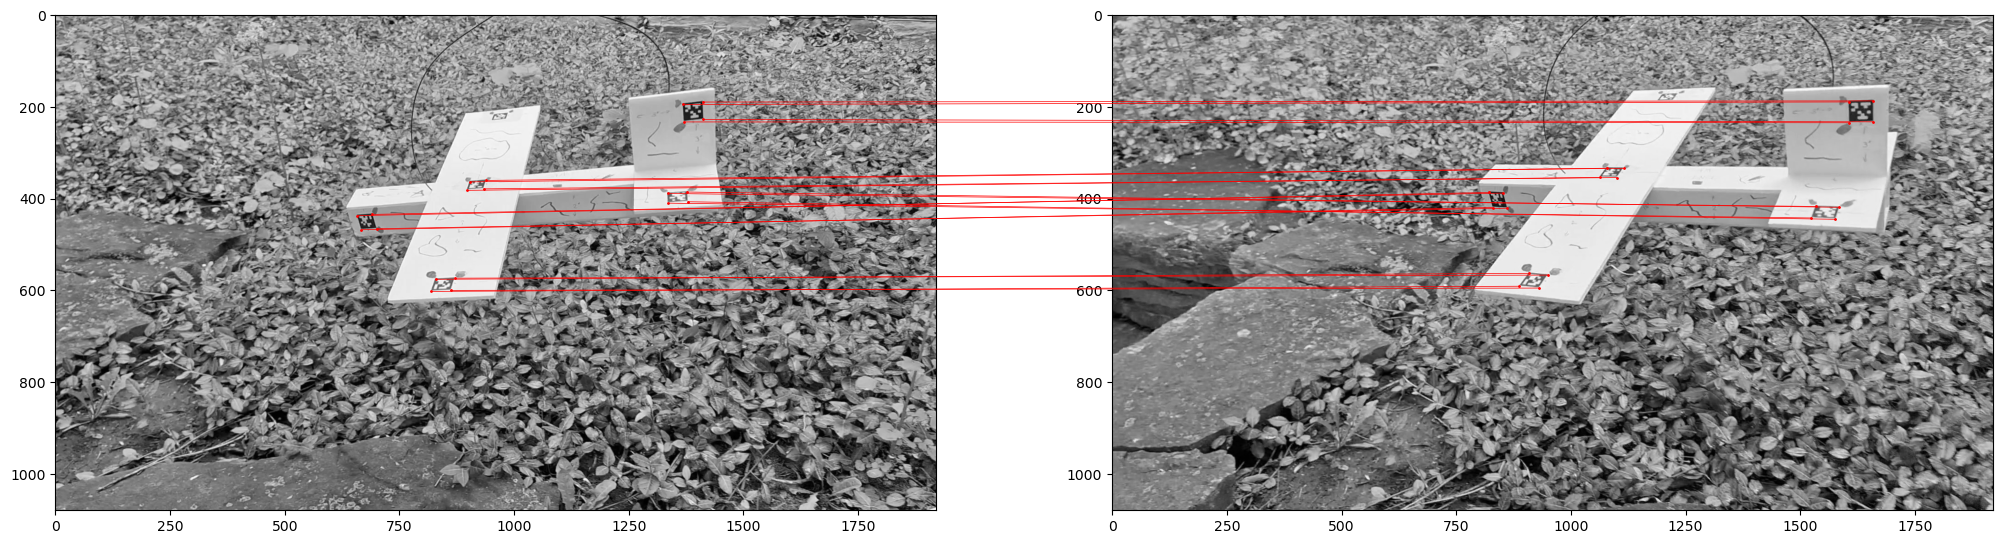

In [22]:
# Create figure
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(25, 15))

# Show images
ax1.imshow(views[0]['img'], cmap='gray') 
ax2.imshow(views[1]['img'], cmap='gray') 

# Show matches
for a_i, b_i in zip(a, b):
    fig.add_artist(
        ConnectionPatch(
            a_i, b_i, 
            'data', 'data',
            axesA=ax1, axesB=ax2,
            color='red',
            connectionstyle='arc3, rad=0.',
            linewidth=0.5,
        )
    )
    # - Draw red dot at each keypoint
    ax1.plot(a_i[0], a_i[1], 'r.', markersize=2)
    ax2.plot(b_i[0], b_i[1], 'r.', markersize=2)

plt.show()

Do reconstruction.

In [23]:
# Estimate essential matrix
E, num_inliers, mask = sfm.getE(a, b, K, rng, threshold=2e-3, num_iters=10000)
print(f'found {num_inliers} inliers')

# Decompose essential matrix to estimate pose and to triangulate points
R_inB_ofA, p_inB_ofA, p_inA = sfm.decomposeE(a, b, K, E)

found 14 inliers


Store results.

In [24]:
print(len(p_inA))
#sfm.myprint(p_inA)
print(len(tracks_tags))

# Store pose estimates
views[0]['R_inB_ofA'] = np.eye(3)
views[0]['p_inB_ofA'] = np.zeros(3)
views[1]['R_inB_ofA'] = R_inB_ofA
views[1]['p_inB_ofA'] = p_inB_ofA

# Always make sure zipped lists are the same length
assert(len(tracks_tags) == len(p_inA))

# Store the position of the point corresponding to each track
for tracks_tag, p_inA_i in zip(tracks_tags, p_inA):
    tracks_tag['p_inA'] = p_inA_i

20
20


Show results

In [25]:
tag_id = 9
corner = 0

pt = np.array([t["corners"][corner] for t in views[0]['tags'] if t["tag_id"] == tag_id][0])
    
print(type(pt))
print(np.array(pt))

print(tracks_tags[0]["p_inA"])

#corners = [data_dict["corners"] for data_dict in tags if data_dict["tagif"] == x]

import sfm
importlib.reload(sfm)


IndexError: list index out of range

POSE ESTIMATES
 [R_inA_ofB0, p_inA_ofB0] = [[    1.0000     0.0000     0.0000     0.0000]
                             [    0.0000     1.0000     0.0000     0.0000]
                             [    0.0000     0.0000     1.0000     0.0000]]
 [R_inA_ofB1, p_inA_ofB1] = [[    0.9798     0.1072    -0.1687     0.5332]
                             [   -0.1023     0.9940     0.0378    -0.1844]
                             [    0.1717    -0.0198     0.9849     0.8257]]

REPROJECTION ERRORS
 Image  0 (   20 points) : (mean, std, max, min) = (  1.21,   1.04,   3.51,   0.04)
 Image  1 (   20 points) : (mean, std, max, min) = (  1.29,   1.10,   3.70,   0.05)


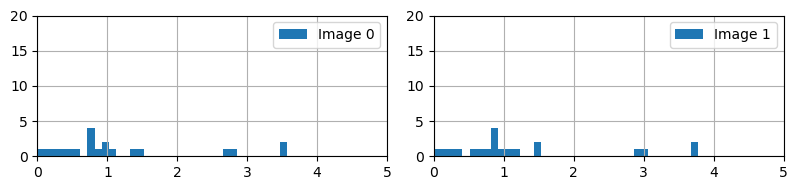

In [26]:
sfm.show_results(views, tracks_tags, K)

Copy results. If you want to start again from here, do the following:

```python
views, tracks = sfm.copy_results(views_1_ini, tracks_1_ini)
```

In [27]:
#views_save = views
#tracks_tags_save = tracks_tags


views_1_ini, tracks_tags_1_ini = sfm.copy_results(views, tracks_tags)


TypeError: list indices must be integers or slices, not str

### Optimize

Create initial values, factors, and optimized keys.

In [28]:
#import sfm
#importlib.reload(sfm)

optimizer, initial_values = sfm.get_optimizer(views, tracks_tags, K)

Iterate over 3 views:
 T_inB0_ofA has an initial value
 T_inB1_ofA has an initial value and is an optimized key
T_inB1_ofA has an sf_scale_residual factor
Iterate over 20 tracks:
 track 0:
  track_0_p_inA has an initial value and is an optimized key
  track_0_b_0 has an initial value and an sf_projection_residual factor
  track_0_b_1 has an initial value and an sf_projection_residual factor

 ...

 track 19:
  track_19_p_inA has an initial value and is an optimized key
  track_19_b_0 has an initial value and an sf_projection_residual factor
  track_19_b_1 has an initial value and an sf_projection_residual factor


Create and run optimizer.

In [29]:
result = optimizer.optimize(initial_values)
assert(result.status == symforce.opt.optimizer.Optimizer.Status.SUCCESS)

[2024-05-09 11:49:36.108] [info] LM<sym::Optimize> [iter    0] lambda: 1.000e+00, error prev/linear/new: 2.046e+01/0.000e+00/1.886e+01, rel reduction: 7.81866e-02
[2024-05-09 11:49:36.110] [info] LM<sym::Optimize> [iter    1] lambda: 1.000e-01, error prev/linear/new: 1.886e+01/0.000e+00/1.536e+01, rel reduction: 1.85655e-01
[2024-05-09 11:49:36.112] [info] LM<sym::Optimize> [iter    2] lambda: 1.000e-02, error prev/linear/new: 1.536e+01/0.000e+00/1.015e+01, rel reduction: 3.38979e-01
[2024-05-09 11:49:36.113] [info] LM<sym::Optimize> [iter    3] lambda: 1.000e-03, error prev/linear/new: 1.015e+01/0.000e+00/8.704e+00, rel reduction: 1.42422e-01
[2024-05-09 11:49:36.115] [info] LM<sym::Optimize> [iter    4] lambda: 1.000e-04, error prev/linear/new: 8.704e+00/0.000e+00/8.565e+00, rel reduction: 1.59640e-02
[2024-05-09 11:49:36.117] [info] LM<sym::Optimize> [iter    5] lambda: 1.000e-05, error prev/linear/new: 8.565e+00/0.000e+00/1.287e+01, rel reduction: -5.03099e-01
[2024-05-09 11:49:36.

Store results from optimization (note that this modifies `views` and `tracks` in place).

In [30]:
#import sfm
#importlib.reload(sfm)

sfm.store_results(views, tracks_tags, K, result, max_reprojection_err=max_reprojection_err)

     2 views with updated pose estimate
    20 valid tracks with updated position estimate
     0 already invalid tracks
     0 newly invalid tracks


Show results.

POSE ESTIMATES
 [R_inA_ofB0, p_inA_ofB0] = [[    1.0000     0.0000     0.0000     0.0000]
                             [    0.0000     1.0000     0.0000     0.0000]
                             [    0.0000     0.0000     1.0000     0.0000]]
 [R_inA_ofB1, p_inA_ofB1] = [[    0.9620     0.1154    -0.2475     0.8014]
                             [   -0.1025     0.9926     0.0644    -0.2849]
                             [    0.2531    -0.0366     0.9667     0.5259]]

REPROJECTION ERRORS
 Image  0 (   20 points) : (mean, std, max, min) = (  0.19,   0.17,   0.55,   0.02)
 Image  1 (   20 points) : (mean, std, max, min) = (  0.17,   0.16,   0.54,   0.02)


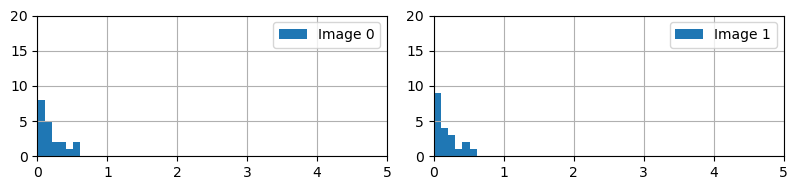

In [31]:
#import sfm
#importlib.reload(sfm)

sfm.show_results(views, tracks_tags, K)

Add visualization of results to the 3D viewer.

In [32]:
sfm.visualize_results(views, tracks_tags, K, frames_per_second)


Copy results. If you want to start again from here, do the following:

```python
views, tracks = sfm.copy_results(views_1_opt, tracks_1_opt)
```

In [26]:
R_inB_ofA_0 = views[0]['R_inB_ofA'].copy()
p_inB_ofA_0 = views[0]['p_inB_ofA'].copy()
R_inA_ofB_0 = R_inB_ofA_0.T
p_inA_ofB_0 = -R_inB_ofA_0.T @ p_inB_ofA_0

R_inB_ofA_1 = views[1]['R_inB_ofA'].copy()
p_inB_ofA_1 = views[1]['p_inB_ofA'].copy()
R_inA_ofB_1 = R_inB_ofA_1.T
p_inA_ofB_1 = -R_inB_ofA_1.T @ p_inB_ofA_1

print(p_inA_ofB_1 - p_inA_ofB_0)

[-0.1797457   0.79768234  0.57568065]


In [84]:
views_1_opt, tracks_1_opt = sfm.copy_results(views, tracks)

## Add a third image

### Get initial guess

Match new images with old images, updating views and tracks.

In [152]:
iC = sfm.add_next_view(views, tracks_tags, K, matching_threshold=matching_threshold)

ADDING VIEW 2


error: OpenCV(4.9.0) :-1: error: (-5:Bad argument) in function 'knnMatch'
> Overload resolution failed:
>  - queryDescriptors is not a numpy array, neither a scalar
>  - Expected Ptr<cv::UMat> for argument 'queryDescriptors'
>  - argument for DescriptorMatcher.knnMatch() given by name ('k') and position (2)
>  - argument for DescriptorMatcher.knnMatch() given by name ('k') and position (2)


Get data for resectioning. Look for tracks that...
* are valid
* have a match with `view_id` that is the same as the new view
* have `p_inA` that is not `None`

Also get data for triangulation. Look for tracks that...
* are valid
* have a match with `view_id` that is the same as the new view
* have `p_inA` that is `None`

In [86]:
tracks_to_resection = []
tracks_to_triangulate = []
for track in tracks:
    if not track['valid']:
        continue
    
    match = sfm.get_match_with_view_id(track['matches'], iC)
    if match is None:
        continue

    if track['p_inA'] is None:
        tracks_to_triangulate.append(track)
    else:
        tracks_to_resection.append(track)

print(f'{len(tracks_to_resection)} tracks to resection')
print(f'{len(tracks_to_triangulate)} tracks to triangulate')

30 tracks to resection
974 tracks to triangulate


#### Resection

The output of this process is an estimate of the pose $R^C_A, p^C_A$.

In [87]:
p_inA = []
c = []
for track in tracks_to_resection:
    assert(track['p_inA'] is not None)
    p_inA.append(track['p_inA'])
    match = sfm.get_match_with_view_id(track['matches'], iC)
    c.append(sfm.get_pt2d_from_match(views, match))
p_inA = np.array(p_inA)
c = np.array(c)

print(f'len(p_inA) = {len(p_inA)}, len(c) = {len(c)}')

len(p_inA) = 30, len(c) = 30


Visualize the image coordinates of points on which PnP will be based.

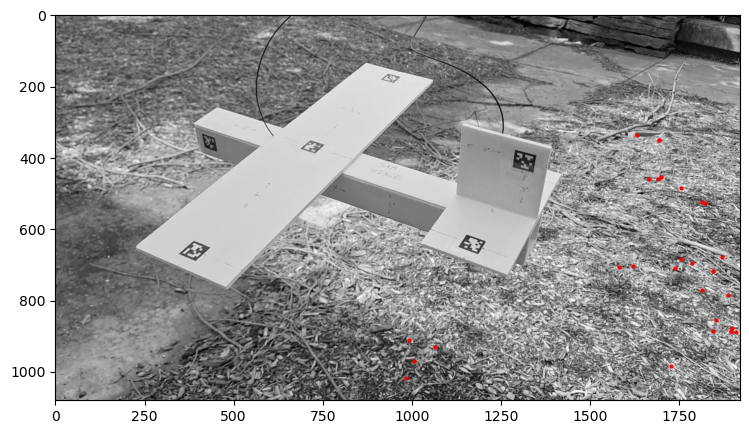

In [88]:
# Create figure
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

# Show image
ax.imshow(views[iC]['img'], cmap='gray')

# Show matches corresponding to points that have already been triangulated
ax.plot(c[:, 0], c[:, 1], 'r.', markersize=4)

# Show plot    
plt.show()

Solve a PnP problem to estimate relative pose.

In [89]:
R_inC_ofA, p_inC_ofA, num_inliers, mask = sfm.resection(
    p_inA,
    c,
    K,
    rng,
    threshold=2.,
    num_iters=1000,
)
print(f'found {num_inliers} inliers out of {len(mask)}')

found 1 inliers out of 30


Store results.

In [90]:
views[iC]['R_inB_ofA'] = R_inC_ofA
views[iC]['p_inB_ofA'] = p_inC_ofA

#### Triangulate

Apply function to triangulate all new tracks. Store results.

In [91]:
for track in tracks_to_triangulate:
    p_inA = sfm.triangulate(track, views, K)
    track['p_inA'] = p_inA

#### Show results

POSE ESTIMATES
 [R_inA_ofB0, p_inA_ofB0] = [[    1.0000     0.0000     0.0000     0.0000]
                             [    0.0000     1.0000     0.0000     0.0000]
                             [    0.0000     0.0000     1.0000     0.0000]]
 [R_inA_ofB1, p_inA_ofB1] = [[    0.9814     0.0936    -0.1678     0.0990]
                             [   -0.1051     0.9926    -0.0609    -0.5407]
                             [    0.1608     0.0773     0.9839     0.8351]]
 [R_inA_ofB2, p_inA_ofB2] = [[    0.9648     0.0697    -0.2537    -0.9385]
                             [   -0.1216     0.9732    -0.1951    -0.5280]
                             [    0.2333     0.2191     0.9474    -0.7316]]

REPROJECTION ERRORS
 Image  0 ( 1681 points) : (mean, std, max, min) = (   nan,    nan,    nan,    nan)
 Image  1 ( 2412 points) : (mean, std, max, min) = (  0.15,   0.37,  11.37,   0.00)
 Image  2 ( 1004 points) : (mean, std, max, min) = (3238.02, 1029.61, 5820.30,   1.96)


/Users/sam/Documents/phd/AE598/Air-to-air-3dv/sfm.py:493: RuntimeWarning: invalid value encountered in divide
  q = np.row_stack([K @ p_inB_i / p_inB_i[2] for p_inB_i in p_inB])


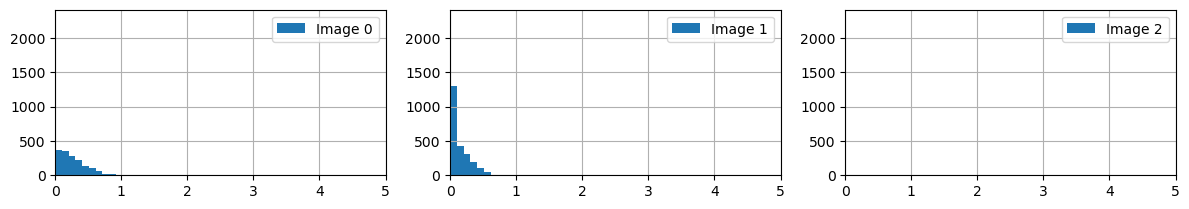

In [92]:
sfm.show_results(views, tracks, K)

Copy results. If you want to start again from here, do the following:

```python
views, tracks = sfm.copy_results(views_2_ini, tracks_2_ini)
```

In [93]:
views_2_ini, tracks_2_ini = sfm.copy_results(views, tracks)

### Optimize

Create initial values, factors, and optimized keys.

In [94]:
optimizer, initial_values = sfm.get_optimizer(views, tracks, K)

Iterate over 4 views:
 T_inB0_ofA has an initial value
 T_inB1_ofA has an initial value and is an optimized key
 T_inB2_ofA has an initial value and is an optimized key
T_inB1_ofA has an sf_scale_residual factor
Iterate over 3017 tracks:

 ...
 track 3016:
  track_3016_p_inA has an initial value and is an optimized key
  track_3016_b_1 has an initial value and an sf_projection_residual factor
  track_3016_b_2 has an initial value and an sf_projection_residual factor


Create and run optimizer.

In [95]:
result = optimizer.optimize(initial_values)
assert(result.status == symforce.opt.optimizer.Optimizer.Status.SUCCESS)

[2024-04-28 18:07:28.733] [info] LM<sym::Optimize> [iter    0] lambda: 1.000e+00, error prev/linear/new: 4.073e+03/0.000e+00/4.072e+03, rel reduction: 2.91722e-04
[2024-04-28 18:07:32.603] [info] LM<sym::Optimize> [iter    1] lambda: 1.000e-01, error prev/linear/new: 4.072e+03/0.000e+00/4.069e+03, rel reduction: 5.43736e-04
[2024-04-28 18:07:35.898] [info] LM<sym::Optimize> [iter    2] lambda: 1.000e-02, error prev/linear/new: 4.069e+03/0.000e+00/4.068e+03, rel reduction: 2.18267e-04
[2024-04-28 18:07:39.293] [info] LM<sym::Optimize> [iter    3] lambda: 1.000e-03, error prev/linear/new: 4.068e+03/0.000e+00/4.068e+03, rel reduction: 8.18586e-05


Store results from optimization (note that this modifies `views` and `tracks` in place).

In [96]:
sfm.store_results(views, tracks, K, result, max_reprojection_err=max_reprojection_err)

     3 views with updated pose estimate
  1516 valid tracks with updated position estimate
   489 already invalid tracks
  1012 newly invalid tracks


Show results.

POSE ESTIMATES
 [R_inA_ofB0, p_inA_ofB0] = [[    1.0000     0.0000     0.0000     0.0000]
                             [    0.0000     1.0000     0.0000     0.0000]
                             [    0.0000     0.0000     1.0000     0.0000]]
 [R_inA_ofB1, p_inA_ofB1] = [[    0.9814     0.0938    -0.1677     0.0981]
                             [   -0.1052     0.9926    -0.0608    -0.5406]
                             [    0.1608     0.0773     0.9840     0.8347]]
 [R_inA_ofB2, p_inA_ofB2] = [[    0.9646     0.0714    -0.2539    -0.9371]
                             [   -0.1235     0.9729    -0.1954    -0.5313]
                             [    0.2331     0.2198     0.9473    -0.7217]]

REPROJECTION ERRORS
 Image  0 ( 1516 points) : (mean, std, max, min) = (  0.26,   0.19,   0.84,   0.00)
 Image  1 ( 1516 points) : (mean, std, max, min) = (  0.20,   0.14,   0.64,   0.00)
 Image  2 (    1 points) : (mean, std, max, min) = (  0.01,   0.00,   0.01,   0.01)


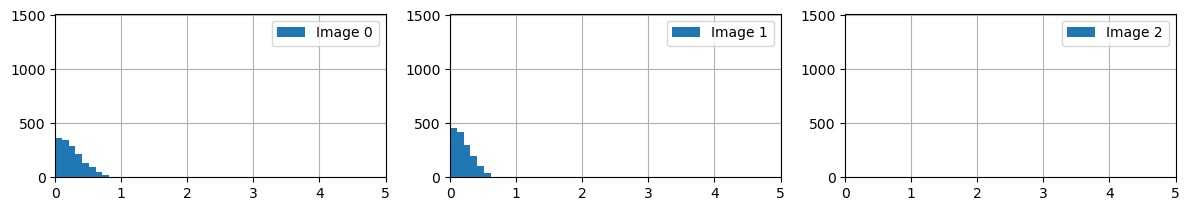

In [97]:
sfm.show_results(views, tracks, K)

Add visualization of results to the 3D viewer.

In [98]:
sfm.visualize_results(views, tracks, K, frames_per_second)

Copy results. If you want to start again from here, do the following:

```python
views, tracks = sfm.copy_results(views_2_opt, tracks_2_opt)
```

In [99]:
views_2_opt, tracks_2_opt = sfm.copy_results(views, tracks)